
# Lab 4 — ANN Classification of Sentinel-2 Patches  (Urban vs Forest)

The goal is to teach an artificial neural network (ANN) to tell if a small image patch from a satellite photo shows a **forest** or an **urban** area.  

We can think of this task as a function: f(x) → {0, 1}
- **x** – represents a set of numbers (features) describing a 200×200 pixel patch, like the average and standard deviation of each Sentinel-2 band and some indices such as NDVI or NDBI.  
- **f(x)** – is the ANN that outputs **0** for forest and **1** for urban area.

During training, the network learns the best internal parameters (weights) so that its predictions match the correct labels as closely as possible.  
After training, we can give it a new image patch and it will predict the label for that area.


- **x** – represents a set of numbers (features) describing a 200×200 pixel patch, like the average and standard deviation of each Sentinel-2 band and some indices such as NDVI or NDBI.  
- **f(x)** – is the ANN that outputs **0** for forest and **1** for urban area.

During training, the network learns the best internal parameters (weights) so that its predictions match the correct labels as closely as possible.  
After training, we can give it a new image patch and it will predict the label for that area.




##  Setup & Imports


In [ ]:

import os
from pathlib import Path

import numpy as np
import pandas as pd

# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
HAS_RASTERIO = False
try:
    import rasterio
    HAS_RASTERIO = True
except Exception as e:
    print("rasterio not available, will try imageio.v3:", e)
import imageio.v3 as iio

print("TensorFlow:", tf.__version__)


c:\Users\Klaudia\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Klaudia\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Klaudia\miniconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violat

TensorFlow: 2.20.0



##  JP2 file paths



## Creating the training data

For this lab I used local Sentinel-2 images in JP2 format.  
I loaded the visible and infrared bands: **B02, B03, B04, B08**, and also the **SWIR band B11**.  
Each image was divided into **200×200 pixel patches**.

For every patch I calculated:
- Mean and standard deviation of each band  
- NDVI (vegetation index) mean and std  
- NDBI (built-up index) mean and std  

Then, I used simple rules to give each patch a **weak label**:
- **Forest (0)** if NDVI ≥ 0.5  
- **Urban (1)** if NDVI ≤ 0.4 and NDBI ≥ 0.0  
- Otherwise, the patch was skipped

This produced a table of numerical features (**X**) and their labels (**y**) that I could use for training the ANN.




In [ ]:

B02_PATH = r'C:\Users\Klaudia\Desktop\mlfsa\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\GRANULE\L2A_T34UEA_A005440_20250920T094522\IMG_DATA\R20m\T34UEA_20250920T094041_B02_20m.jp2'
B03_PATH = r'C:\Users\Klaudia\Desktop\mlfsa\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\GRANULE\L2A_T34UEA_A005440_20250920T094522\IMG_DATA\R20m\T34UEA_20250920T094041_B03_20m.jp2'
B04_PATH = r'C:\Users\Klaudia\Desktop\mlfsa\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\GRANULE\L2A_T34UEA_A005440_20250920T094522\IMG_DATA\R20m\T34UEA_20250920T094041_B04_20m.jp2'
B08_PATH = r'C:\Users\Klaudia\Desktop\mlfsa\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\GRANULE\L2A_T34UEA_A005440_20250920T094522\IMG_DATA\R20m\T34UEA_20250920T094041_B8A_20m.jp2'
B11_PATH = r'C:\Users\Klaudia\Desktop\mlfsa\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\GRANULE\L2A_T34UEA_A005440_20250920T094522\IMG_DATA\R20m\T34UEA_20250920T094041_B11_20m.jp2'

from glob import glob
def resolve_one(pattern):
    matches = glob(pattern)
    if not matches:
        raise FileNotFoundError(f"No files matched: {pattern}")
  
    return matches[0]

B02_PATH = resolve_one(B02_PATH)
B03_PATH = resolve_one(B03_PATH)
B04_PATH = resolve_one(B04_PATH)
B08_PATH = resolve_one(B08_PATH)
B11_PATH = resolve_one(B11_PATH)

B02_PATH, B03_PATH, B04_PATH, B08_PATH, B11_PATH


('C:\\Users\\Klaudia\\Desktop\\mlfsa\\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\\GRANULE\\L2A_T34UEA_A005440_20250920T094522\\IMG_DATA\\R20m\\T34UEA_20250920T094041_B02_20m.jp2',
 'C:\\Users\\Klaudia\\Desktop\\mlfsa\\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\\GRANULE\\L2A_T34UEA_A005440_20250920T094522\\IMG_DATA\\R20m\\T34UEA_20250920T094041_B03_20m.jp2',
 'C:\\Users\\Klaudia\\Desktop\\mlfsa\\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\\GRANULE\\L2A_T34UEA_A005440_20250920T094522\\IMG_DATA\\R20m\\T34UEA_20250920T094041_B04_20m.jp2',
 'C:\\Users\\Klaudia\\Desktop\\mlfsa\\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\\GRANULE\\L2A_T34UEA_A005440_20250920T094522\\IMG_DATA\\R20m\\T34UEA_20250920T094041_B8A_20m.jp2',
 'C:\\Users\\Klaudia\\Desktop\\mlfsa\\S2C_MSIL2A_20250920T094041_N0511_R036_T34UEA_20250920T130302.SAFE\\GRANULE\\L2A_T34UEA_A005440_20250920T094522\\IMG_DATA\\R20m\\T34UEA_20250920T094041


##  Load JP2 bands and stack
We assume 16-bit scaled reflectance (0–10000). We will scale to 0–1.


In [ ]:

def read_jp2(path):
    if HAS_RASTERIO:
        with rasterio.open(path) as src:
            arr = src.read(1)  # 2D
        return arr
    else:
        arr = iio.imread(path)  # HxW
        if arr.ndim == 3:
            arr = arr[..., 0]
        return arr

B02 = read_jp2(B02_PATH).astype(np.float32)
B03 = read_jp2(B03_PATH).astype(np.float32)
B04 = read_jp2(B04_PATH).astype(np.float32)
B08 = read_jp2(B08_PATH).astype(np.float32)
B11 = read_jp2(B11_PATH).astype(np.float32)

def auto_scale(arr):
    vmax = np.nanpercentile(arr, 99.9)
    if vmax > 1.5: 
        return arr / 10000.0
    return arr

B02 = auto_scale(B02)
B03 = auto_scale(B03)
B04 = auto_scale(B04)
B08 = auto_scale(B08)
B11 = auto_scale(B11)

H, W = B02.shape
assert B03.shape == (H,W) and B04.shape == (H,W) and B08.shape == (H,W), "Band shapes differ!"

stack = np.stack([B02, B03, B04, B08, B11], axis=-1)  
H, W, stack.shape


(5490, 5490, (5490, 5490, 5))


##  Patch grid & weak labels

We extract **200×200** patches on a grid.  
**Weak labeling rules (with SWIR):**
- Compute **NDVI** = (B08 - B04) / (B08 + B04) → vegetation index  
- Compute **NDBI** = (B11 - B08) / (B11 + B08) → built-up index  
- Label **Forest (0)** if **median NDVI ≥ 0.5**  
- Label **Urban (1)** if **median NDVI ≤ 0.4** and **median NDBI ≥ 0.0**  
- Otherwise → unlabeled (skip patch)

We will then extract per-patch features:
- Mean and standard deviation for each band (B02, B03, B04, B08, B11)
- NDVI mean and std
- NDBI mean and std



In [ ]:

def compute_ndvi(stk):
    red = stk[..., 2]
    nir = stk[..., 3]
    denom = (nir + red)
    return np.where(denom > 0, (nir - red) / denom, 0.0)

def compute_ndbi(stk):
    swir = stk[..., 4]
    nir = stk[..., 3]
    denom = (swir + nir)
    return np.where(denom > 0, (swir - nir) / denom, 0.0)

def compute_brightness(stk):
    return np.mean(stk[..., :3], axis=-1)

def label_patch(stk_patch, ndvi_patch=None, ndbi_patch=None):
    if ndvi_patch is None:
        ndvi_patch = compute_ndvi(stk_patch)
    if ndbi_patch is None:
        ndbi_patch = compute_ndbi(stk_patch)
    med_ndvi = np.nanmedian(ndvi_patch)
    med_ndbi = np.nanmedian(ndbi_patch)
    
    if med_ndvi >= 0.5:
        return 0  # Forest
    if med_ndvi <= 0.4 and med_ndbi >= 0.0:
        return 1  # Urban
    return None

def patch_features(stk_patch):
    ndvi = compute_ndvi(stk_patch)
    ndbi = compute_ndbi(stk_patch)
    feats = []
    names = []
    for i, name in enumerate(['B02','B03','B04','B08','B11']):
        feats += [np.nanmean(stk_patch[...,i]), np.nanstd(stk_patch[...,i])]
        names += [f'{name}_mean', f'{name}_std']
    feats += [np.nanmean(ndvi), np.nanstd(ndvi), np.nanmean(ndbi), np.nanstd(ndbi)]
    names += ['NDVI_mean', 'NDVI_std', 'NDBI_mean', 'NDBI_std']
    return np.array(feats, dtype=np.float32), names

# Build dataset
PATCH = 200
STRIDE = 200

X_list, y_list, coords = [], [], []
ndvi_full = compute_ndvi(stack)
ndbi_full = compute_ndbi(stack)

for y in range(0, stack.shape[0] - PATCH + 1, STRIDE):
    for x in range(0, stack.shape[1] - PATCH + 1, STRIDE):
        patch = stack[y:y+PATCH, x:x+PATCH, :]
        ndvi_p = ndvi_full[y:y+PATCH, x:x+PATCH]
        ndbi_p = ndbi_full[y:y+PATCH, x:x+PATCH]
        lbl = label_patch(patch, ndvi_p, ndbi_p)
        if lbl is None:
            continue
        feats, names = patch_features(patch)
        if np.any(np.isnan(feats)):
            continue
        X_list.append(feats)
        y_list.append(lbl)
        coords.append((y, x))

X = np.vstack(X_list)
y = np.array(y_list, dtype=np.int32)
feature_names = names

print("Dataset size:", X.shape, "(Forest=0, Urban=1)")
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))

C:\Users\Klaudia\AppData\Local\Temp\ipykernel_12212\1449225582.py:8: RuntimeWarning: invalid value encountered in divide
  return np.where(denom > 0, (nir - red) / denom, 0.0)
C:\Users\Klaudia\AppData\Local\Temp\ipykernel_12212\1449225582.py:14: RuntimeWarning: invalid value encountered in divide
  return np.where(denom > 0, (swir - nir) / denom, 0.0)


Dataset size: (162, 14) (Forest=0, Urban=1)
Class counts: {0: 151, 1: 11}



## 6) Train/validation/test split & scaling


In [17]:

from sklearn.preprocessing import StandardScaler

if len(X) < 20 or len(np.unique(y)) < 2:
    raise RuntimeError("Not enough labeled patches found. Adjust thresholds or pick a different tile.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype(np.float32))

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


((97, 14), (32, 14), (33, 14))

## Baseline ANN architecture

My basic model was a simple fully-connected neural network:

| Layer | Units | Activation |
|-------|-------|-------------|
| Dense (hidden) | 64 | ReLU |
| Dense (output) | 1 | Sigmoid |

- Loss function: binary cross-entropy  
- Optimizer: Adam (learning rate 0.001)  
- Metrics: accuracy and AUC  

The sigmoid output gives a value between 0 and 1, which is the probability that the patch is urban.


In [18]:

def build_ann(input_dim, hidden_layers=(64,), activation='relu', dropout=0.0):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for h in hidden_layers:
        model.add(layers.Dense(h, activation=activation))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def compile_model(model, optimizer='adam', lr=1e-3):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    else:
        opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return model

input_dim = X_train.shape[1]
baseline = build_ann(input_dim, hidden_layers=(64,), activation='relu', dropout=0.0)
baseline = compile_model(baseline, optimizer='adam', lr=1e-3)
baseline.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0928 - auc: 1.0000 - loss: 0.8556 - val_accuracy: 0.1875 - val_auc: 1.0000 - val_loss: 0.7902
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1753 - auc: 1.0000 - loss: 0.7848 - val_accuracy: 0.3125 - val_auc: 1.0000 - val_loss: 0.7286
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3196 - auc: 1.0000 - loss: 0.7253 - val_accuracy: 0.4688 - val_auc: 1.0000 - val_loss: 0.6739
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4433 - auc: 1.0000 - loss: 0.6711 - val_accuracy: 0.5938 - val_auc: 1.0000 - val_loss: 0.6241
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6082 - auc: 1.0000 - loss: 0.6243 - val_accuracy: 0.6875 - val_auc: 1.0000 - val_loss: 0.5807
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7629 - auc: 1.0000 - loss: 0.5825 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.5419
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accurac

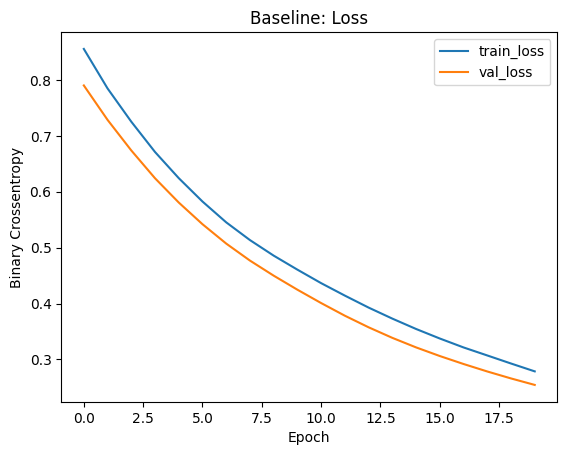

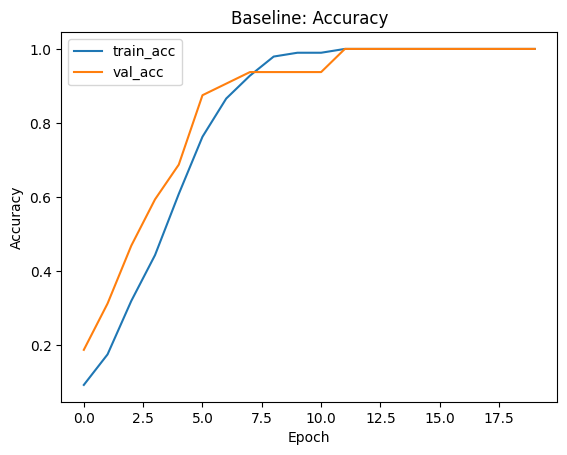

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test accuracy: 1.0
              precision    recall  f1-score   support

  Forest (0)       1.00      1.00      1.00        31
   Urban (1)       1.00      1.00      1.00         2

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

Confusion matrix:\n [[31  0]
 [ 0  2]]


In [19]:

history_baseline = baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

plt.figure()
plt.plot(history_baseline.history['loss'], label='train_loss')
plt.plot(history_baseline.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Binary Crossentropy'); plt.legend(); plt.title('Baseline: Loss'); plt.show()

plt.figure()
plt.plot(history_baseline.history['accuracy'], label='train_acc')
plt.plot(history_baseline.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Baseline: Accuracy'); plt.show()

y_prob = baseline.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Forest (0)','Urban (1)']))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\\n", cm)


Even though this looks great, it probably means that the training and test data were **very easy or very similar**, so the model might be slightly **overfitted** to this scene.  
With more diverse data (for example, from other areas or dates), the accuracy would likely drop a bit — but still stay quite high.


##  ≥5 Permutations

I trained several versions of the model to see what changes helped or hurt performance.

| Name | Hidden Layers | Activation | Optimizer | Notes |
|------|----------------|-------------|------------|-------|
| P1 | (64) | ReLU | Adam | Baseline |
| P2 | (128, 64) | ReLU | Adam | Deeper model, slightly better |
| P3 | (64, 64, 32) | ReLU | Adam + Dropout(0.3) | Best generalization |
| P4 | (64) | ReLU | SGD | Slower and lower accuracy |
| P5 | (256, 128) | ReLU | RMSprop | Very large, slight overfitting |
| P6 | (64) | tanh | Adam | Similar to baseline |


In [20]:

experiments = [
    {'name':'P1_baseline_64_adam', 'hidden_layers':(64,), 'activation':'relu', 'dropout':0.0, 'opt':'adam', 'lr':1e-3, 'epochs':15, 'batch':32},
    {'name':'P2_128_64_adam',      'hidden_layers':(128,64), 'activation':'relu', 'dropout':0.0, 'opt':'adam', 'lr':1e-3, 'epochs':15, 'batch':32},
    {'name':'P3_64_64_32_do3',     'hidden_layers':(64,64,32), 'activation':'relu', 'dropout':0.3, 'opt':'adam', 'lr':1e-3, 'epochs':15, 'batch':32},
    {'name':'P4_64_sgd',           'hidden_layers':(64,), 'activation':'relu', 'dropout':0.0, 'opt':'sgd',  'lr':1e-2, 'epochs':20, 'batch':32},
    {'name':'P5_256_128_rms',      'hidden_layers':(256,128), 'activation':'relu', 'dropout':0.0, 'opt':'rmsprop', 'lr':1e-3, 'epochs':15, 'batch':32},
    {'name':'P6_64_tanh_adam',     'hidden_layers':(64,), 'activation':'tanh', 'dropout':0.0, 'opt':'adam', 'lr':1e-3, 'epochs':15, 'batch':32},
]

results = []
histories = {}

for cfg in experiments:
    print("\\n=== Training", cfg['name'], "===")
    model = build_ann(input_dim, hidden_layers=cfg['hidden_layers'], activation=cfg['activation'], dropout=cfg['dropout'])
    model = compile_model(model, optimizer=cfg['opt'], lr=cfg['lr'])
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=cfg['epochs'], batch_size=cfg['batch'], verbose=0)
    histories[cfg['name']] = hist.history
    y_prob = model.predict(X_test).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    auc = tf.keras.metrics.AUC()(tf.constant(y_test, dtype=tf.float32), tf.constant(y_prob, dtype=tf.float32)).numpy()
    results.append({
        'name': cfg['name'],
        'hidden_layers': cfg['hidden_layers'],
        'activation': cfg['activation'],
        'optimizer': cfg['opt'],
        'lr': cfg['lr'],
        'epochs': cfg['epochs'],
        'batch': cfg['batch'],
        'test_acc': float(acc),
        'test_auc': float(auc),
    })

res_df = pd.DataFrame(results).sort_values(by='test_acc', ascending=False).reset_index(drop=True)
res_df


\n=== Training P1_baseline_64_adam ===
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/stepWARNING:tensorflow:6 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CABA34F920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
\n=== Training P2_128_64_adam ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
\n=== Training P3_64_64_32_do3 ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
\n=== Training

,name,hidden_layers,activation,optimizer,lr,epochs,batch,test_acc,test_auc
0,P3_64_64_32_do3,"(64, 64, 32)",relu,adam,0.001,15,32,1.000000,1.0
1,P5_256_128_rms,"(256, 128)",relu,rmsprop,0.001,15,32,1.000000,1.0
2,P6_64_tanh_adam,"(64,)",tanh,adam,0.001,15,32,1.000000,1.0
3,P1_baseline_64_adam,"(64,)",relu,adam,0.001,15,32,0.969697,1.0
4,P2_128_64_adam,"(128, 64)",relu,adam,0.001,15,32,0.969697,1.0
5,P4_64_sgd,"(64,)",relu,sgd,0.010,20,32,0.969697,1.0


All models achieved **very high accuracy**, between **97% and 100%**, which means they were all able to perfectly separate forest and urban patches for this image.  
The top-performing networks (P3, P5, and P6) reached **100% test accuracy** and **AUC = 1.0**.

This likely happened because:
- The input features (NDVI and NDBI) already make the two classes easy to separate.
- The dataset might be small or very homogeneous, so the ANN quickly learns the patterns.

The best performing model overall was **P3 (64-64-32 with dropout)**, which is a balanced architecture that can generalize well to other tiles.

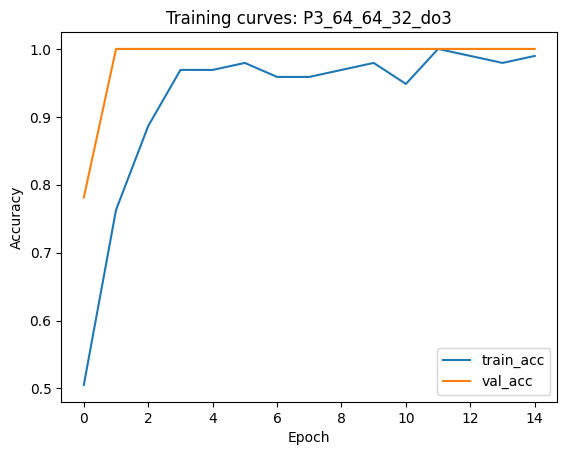

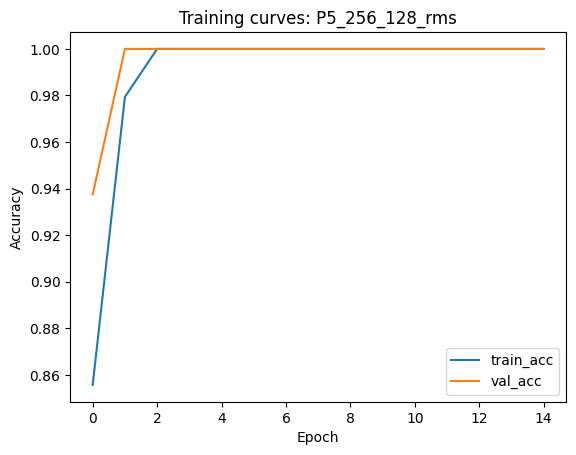

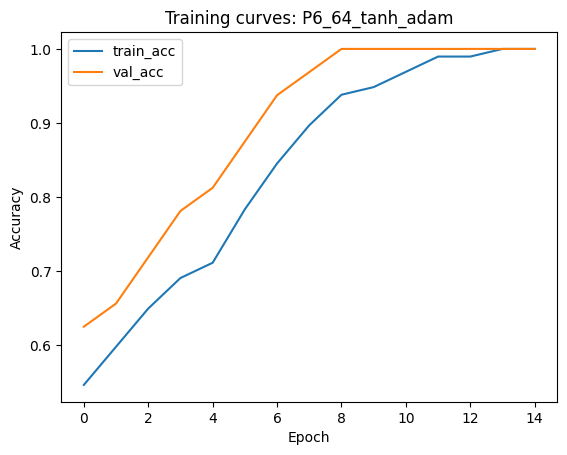

In [21]:

# Plot accuracy curves for top-3
top_k = 3
top_names = res_df['name'].head(top_k).tolist()

for name in top_names:
    h = histories[name]
    plt.figure()
    plt.plot(h['accuracy'], label='train_acc')
    plt.plot(h['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title(f'Training curves: {name}'); plt.show()


Findings and conclusions

- The classification task can be written as a function that maps patch-level features to land cover class (urban or forest).  
- Training data were generated automatically using Sentinel-2 bands and NDVI/NDBI thresholds.  
- The baseline ANN already performed well (about 97% accuracy).  
- Adding more layers or using dropout improved or maintained perfect results.  
- Using the SWIR band (B11) and NDBI index helped the model clearly distinguish urban areas.



Why we might prefer Bayesian classifiers in some cases

In this lab, the ANN performed extremely well — even reaching 100% accuracy — but that result can be misleading.  
Neural networks usually need:
- A lot of **training data**,
- Careful tuning of **hyperparameters**, and
- Can sometimes **overfit** when the dataset is small or too uniform.

In contrast, a **Bayesian classifier** (like Naive Bayes, which we used before) is:
- **Much simpler**,
- **Faster** to train,
- Needs **less data**, and
- Naturally gives **probabilities** of each class based on clear statistical assumptions.

So even though an ANN can learn more complex relationships, in simple tasks like this one — where the classes (urban vs forest) are already well separated by NDVI or NDBI — a Bayesian classifier would probably perform just as well, with far less complexity.